In [24]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
path = '/kaggle/input/mushrooms-classification-common-genuss-images/mushrooms/Mushrooms/'
df = pd.DataFrame()
for imlabel in os.listdir(path):
    for image in os.listdir(path+imlabel):
        df = df.append({"path" : path+imlabel+"/"+image, "label" : imlabel}, ignore_index=True)

df.head()

,path,label
0,/kaggle/input/mushrooms-classification-common-...,Entoloma
1,/kaggle/input/mushrooms-classification-common-...,Entoloma
2,/kaggle/input/mushrooms-classification-common-...,Entoloma
3,/kaggle/input/mushrooms-classification-common-...,Entoloma
4,/kaggle/input/mushrooms-classification-common-...,Entoloma


## Splitting Data :
70%, 20%, 10% for training, validation and testing respecitvely

In [26]:
train_X, val_test_X, train_Y, val_test_Y = train_test_split(df['path'], df['label'], test_size=0.3, shuffle=True)
train_data = pd.concat({'path':train_X, 'label':train_Y}, axis=1)

val_X, test_X, val_Y, test_Y = train_test_split(val_test_X, val_test_Y, test_size=0.33, shuffle=True)

validation_data = pd.concat({'path':val_X, 'label':val_Y}, axis=1)
test_data = pd.concat({'path':test_X, 'label':test_Y}, axis=1)

In [27]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
vertical_flip = True)
train_data_generator = train_datagen.flow_from_dataframe(train_data,
                                                         x_col = 'path',
                                                         y_col = 'label',
                                                        batch_size=32,
                                                         color_mode="rgb",
                                                         target_size=(224, 224),
                                                        class_mode="categorical")
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_data_generator = validation_datagen.flow_from_dataframe(validation_data,
                                                                   x_col = 'path',
                                                                   y_col = 'label',
                                                                   batch_size=32,
                                                                   color_mode="rgb",
                                                                   target_size=(224, 224),
                                                                   class_mode="categorical")

test_datagen = ImageDataGenerator(rescale=1./255)
test_data_generator = test_datagen.flow_from_dataframe(test_data,
                                         x_col = 'path',
                                          y_col = 'label',
                                          batch_size=test_data['path'].shape[0],
                                          color_mode="rgb",
                                          target_size=(224, 224),
                                          class_mode="categorical")

Found 4699 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 665 validated image filenames belonging to 9 classes.


In [28]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint ,EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report

In [29]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [30]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [31]:
xceptionNet = tensorflow.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

In [32]:
resNet = tensorflow.keras.applications.resnet.ResNet101(
    include_top=False, weights='imagenet',
    input_shape=(224, 224, 3)
)

In [33]:
img_inputs = tensorflow.keras.Input(shape=(224, 224, 3))

x = densenet(img_inputs)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
x = tensorflow.keras.layers.Dense(128, activation='relu')(x)

y = xceptionNet(img_inputs)
y = tensorflow.keras.layers.GlobalAveragePooling2D()(y)
y = tensorflow.keras.layers.Dense(128, activation='relu')(y)

z = resNet(img_inputs)
z = tensorflow.keras.layers.GlobalAveragePooling2D()(z)
z = tensorflow.keras.layers.Dense(128, activation='relu')(z)

z = tensorflow.keras.layers.Concatenate()([x, y, z])
m_output = tensorflow.keras.layers.Dense(9, activation='softmax')(z)

model2 = keras.Model(inputs=img_inputs, outputs=m_output)

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m, precision_m, recall_m])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet121 (Functional)        (None, 7, 7, 1024)   7037504     input_8[0][0]                    
__________________________________________________________________________________________________
xception (Functional)           (None, 7, 7, 2048)   20861480    input_8[0][0]                    
__________________________________________________________________________________________________
resnet101 (Functional)          (None, 7, 7, 2048)   42658176    input_8[0][0]                    
____________________________________________________________________________________________

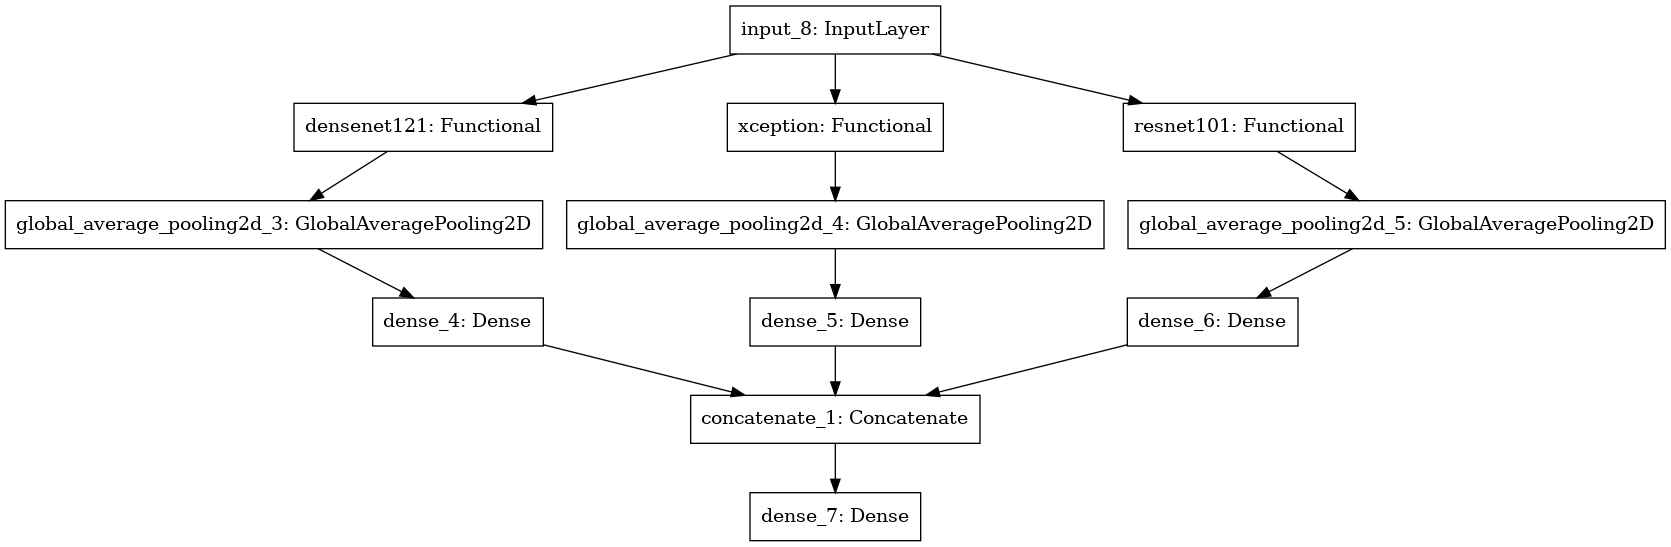

In [34]:
tensorflow.keras.utils.plot_model(model2)

In [35]:
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

early = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.09,patience=2)

history = model2.fit(train_data_generator, epochs=2, validation_data=validation_data_generator, callbacks=[early, reduce_lr])

Epoch 1/2
147/147 [==============================] - 187s 1s/step - loss: 1.4267 - accuracy: 0.5029 - f1_m: 0.4361 - precision_m: 0.6818 - recall_m: 0.3289 - val_loss: 62.9511 - val_accuracy: 0.1911 - val_f1_m: 0.1875 - val_precision_m: 0.1875 - val_recall_m: 0.1875
Epoch 2/2
147/147 [==============================] - 157s 1s/step - loss: 1.0541 - accuracy: 0.6384 - f1_m: 0.6092 - precision_m: 0.7612 - recall_m: 0.5113 - val_loss: 1.9827 - val_accuracy: 0.4422 - val_f1_m: 0.4378 - val_precision_m: 0.5189 - val_recall_m: 0.3803


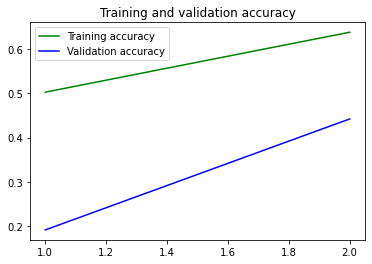

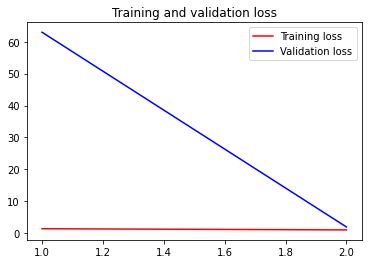

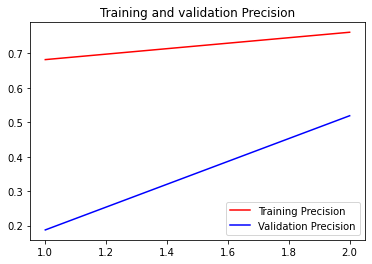

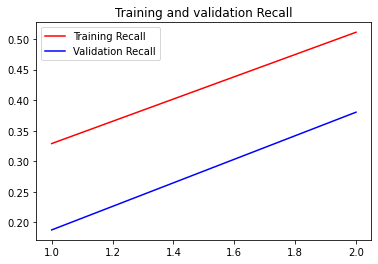

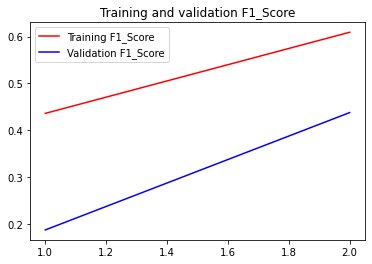

In [36]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision_m']
val_precision = history.history['val_precision_m']
recall = history.history['recall_m']
val_recall = history.history['val_recall_m']
f1_score = history.history['f1_m']
val_f1_score = history.history['val_f1_m']

import matplotlib.pyplot as plt

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, precision, 'r', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
plt.title('Training and validation Precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'r', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.figure()

plt.plot(epochs, f1_score, 'r', label='Training F1_Score')
plt.plot(epochs, val_f1_score, 'b', label='Validation F1_Score')
plt.title('Training and validation F1_Score')
plt.legend()
plt.show()

In [37]:
for image, lab in test_data_generator:
    break;

predict_y = model2.predict(image)

## Confusion Matrix heatmap

[Text(0.5, 15.0, 'prediction'), Text(33.0, 0.5, 'true_value')]

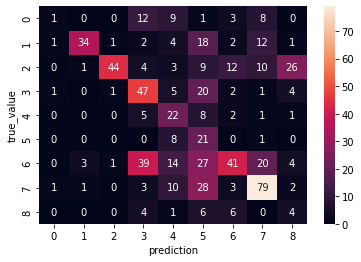

In [38]:
import seaborn as sns

cnf = tensorflow.math.confusion_matrix(np.argmax(lab, axis=1), np.argmax(predict_y, axis=1))
c_plot = sns.heatmap(cnf, annot=True)
c_plot.set(xlabel='prediction', ylabel='true_value')

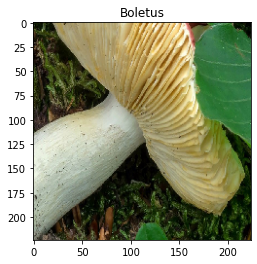

True prediction


In [39]:
def show_predicted_image(i):
    plt.imshow(image[i])
    plt.title(os.listdir(path)[np.argmax(predict_y[i])])
    plt.show()
    if (np.argmax(predict_y[i])==np.argmax(lab[i])):
        print("True prediction")
    else:
        print("Wrong value prediction")
        print(f"Correct label is : {os.listdir(path)[np.argmax(lab[i])]}")
        
show_predicted_image(4)

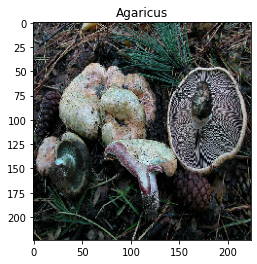

Wrong value prediction
Correct label is : Russula


In [40]:
show_predicted_image(17)

## Test data Classification Report : 

## Classification report for test datset

In [41]:
print(classification_report(np.argmax(lab, axis=1), np.argmax(predict_y, axis=1)))

              precision    recall  f1-score   support

           0       0.25      0.03      0.05        34
           1       0.87      0.45      0.60        75
           2       0.94      0.40      0.56       109
           3       0.41      0.58      0.48        81
           4       0.29      0.56      0.38        39
           5       0.15      0.70      0.25        30
           6       0.58      0.28      0.37       149
           7       0.60      0.62      0.61       127
           8       0.10      0.19      0.13        21

    accuracy                           0.44       665
   macro avg       0.46      0.42      0.38       665
weighted avg       0.58      0.44      0.46       665

